In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms


In [2]:
# Load MNIST and Fashion-MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_mnist  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_fmnist = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# If short on compute, sample smaller training set
subset_size = len(train_mnist)  # optional smaller training set
indices = np.random.choice(len(train_mnist), subset_size, replace=False)
train_subset = torch.utils.data.Subset(train_mnist, indices)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_mnist, batch_size=256, shuffle=False)



In [3]:
# Define the MLP (30 → 20 → 10)
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        emb = F.relu(self.fc2(x))  # 20-neuron layer
        out = self.fc3(emb)
        return out, emb



In [4]:
# Train the MLP
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out, _ = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss = {total_loss/len(train_loader):.4f}")



Epoch 1/10, Loss = 0.6497
Epoch 2/10, Loss = 0.3064
Epoch 3/10, Loss = 0.2613
Epoch 4/10, Loss = 0.2352
Epoch 5/10, Loss = 0.2169
Epoch 6/10, Loss = 0.2025
Epoch 7/10, Loss = 0.1940
Epoch 8/10, Loss = 0.1832
Epoch 9/10, Loss = 0.1721
Epoch 10/10, Loss = 0.1668


MLP Test Accuracy: 0.9445, F1: 0.9439


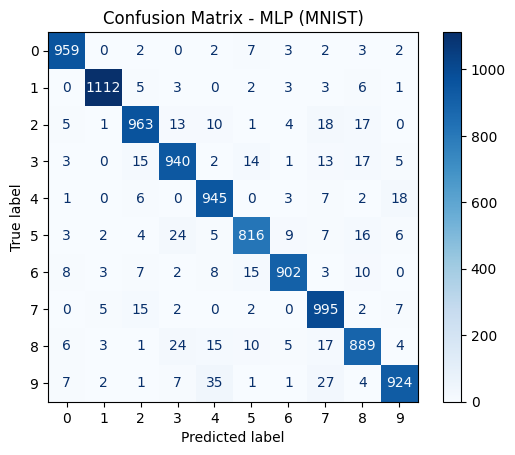

In [5]:
# Evaluate MLP on MNIST test set
model.eval()
y_true, y_pred = [], []
embeddings = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        out, emb = model(imgs)
        preds = out.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())
        embeddings.append(emb.cpu().numpy())

embeddings = np.concatenate(embeddings)
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
print(f"MLP Test Accuracy: {acc:.4f}, F1: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Confusion Matrix - MLP (MNIST)")
plt.show()



Training Logistic Regression...
Accuracy (LogReg): 0.9261 F1 Score:  0.9249803014369521


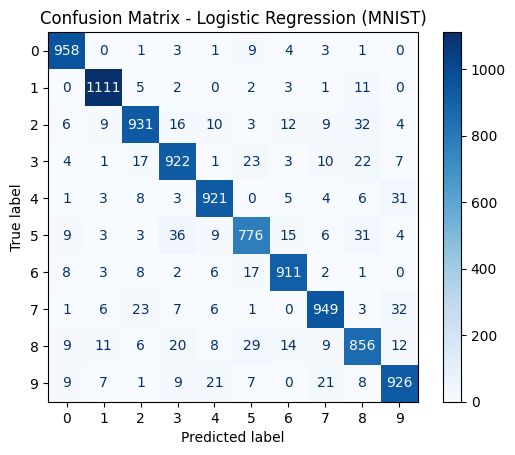

Training Random Forest...
Accuracy (Random Forest): 0.9699 F1 score:  0.943861796337457


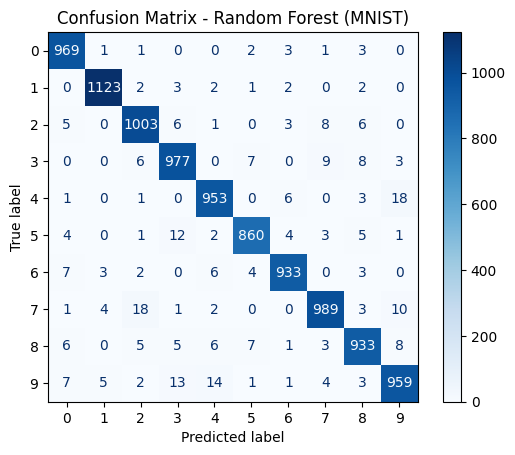

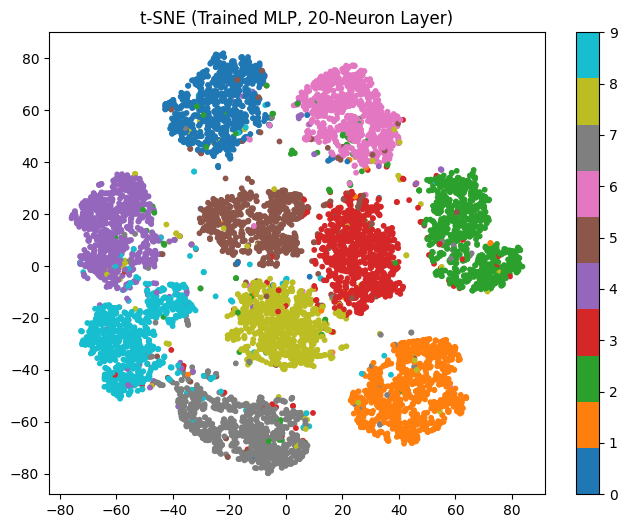

In [10]:
# Compare with Logistic Regression and Random Forest
# Flatten MNIST images
X_train = train_subset.dataset.data[train_subset.indices].numpy().reshape(subset_size, -1) / 255.0
y_train = train_subset.dataset.targets[train_subset.indices].numpy()
X_test = test_mnist.data.numpy().reshape(-1, 28*28) / 255.0
y_test = test_mnist.targets.numpy()

print("Training Logistic Regression...")
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
y_pred_lr = lr_clf.predict(X_test)
f1_lr = f1_score(y_true, y_pred_lr, average='macro')
print("Accuracy (LogReg):", accuracy_score(y_test, y_pred_lr), "F1 Score: ", f1_lr)
cm_lr = confusion_matrix(y_true, y_pred_lr)
ConfusionMatrixDisplay(cm_lr).plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (MNIST)")
plt.show()


print("Training Random Forest...")
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
f1_rf = f1_score(y_true, y_pred, average='macro')
print("Accuracy (Random Forest):", accuracy_score(y_test, y_pred_rf), "F1 score: ", f1_rf)
cm_rf = confusion_matrix(y_true, y_pred_rf)
ConfusionMatrixDisplay(cm_rf).plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest (MNIST)")
plt.show()


# t-SNE Visualization (Trained vs Untrained)
def plot_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8,6))
    plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='tab10', s=10)
    plt.colorbar()
    plt.title(title)
    plt.show()

# Trained embeddings
plot_tsne(embeddings, y_true, "t-SNE (Trained MLP, 20-Neuron Layer)")



We can see from the results that our MLP has an accuracy of 94.45% and F1 score of 0.94. On the other hand logistic regression has an accuracy of 92.6% and F1 score of 0.925. Whereas, Random Forest has an accuracy of 97% and F1 score of 0.94. So we can see that all the three models are performing very similarly. Since both the accuracy and F1 score are quite high, we can say that the models are doing a good job of classifying the images. 

As for misclassifications, we can see from the confusion matrix that misclassifications are spread out quite randomly for all three models and there is no inherent pattern in them. This tells us that the model is not biased towards any particular class- which is a good thing.

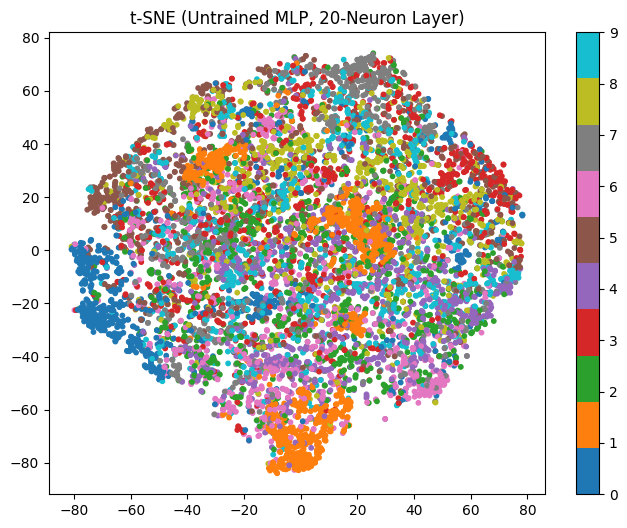

In [7]:
# Untrained embeddings
untrained_model = MLP().to(device)
untrained_emb = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        _, emb = untrained_model(imgs)
        untrained_emb.append(emb.cpu().numpy())
untrained_emb = np.concatenate(untrained_emb)
plot_tsne(untrained_emb, y_true, "t-SNE (Untrained MLP, 20-Neuron Layer)")



Now let us compare the t-SNE (t-distributed stochastic neighbor embedding) plots for our MLP for trained and untrained data. As we can see in the above plots, when the model in untrained, the data points are scattered completely randomly and there is no way to distinguish between different classes. But, for trained model, we can see the t-SNE plot shows very clear differentiation of classes. There are a mismatched points of course, but overall the model is able to distiguish the classes quite well. This is also consistent with the high accuracy and F1 score of the model.

Cross-Domain (Fashion-MNIST) Accuracy: 0.1015


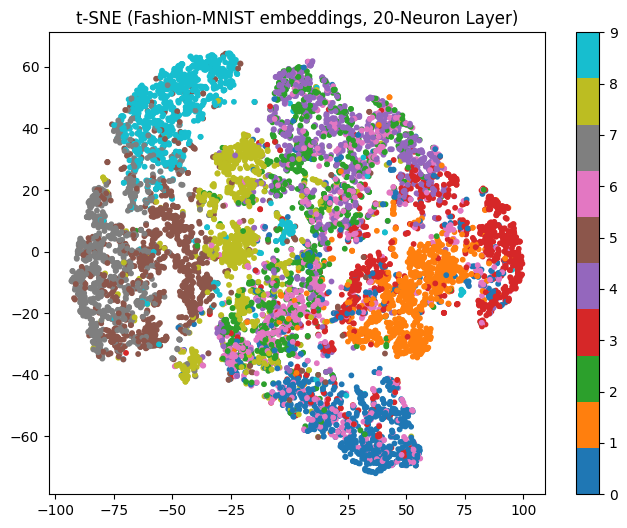

In [8]:
# Cross-Domain Test on Fashion-MNIST
fashion_loader = DataLoader(test_fmnist, batch_size=256, shuffle=False)
y_fm_true, y_fm_pred, fm_embeds = [], [], []

with torch.no_grad():
    for imgs, labels in fashion_loader:
        imgs = imgs.to(device)
        out, emb = model(imgs)
        preds = out.argmax(dim=1).cpu().numpy()
        y_fm_pred.extend(preds)
        y_fm_true.extend(labels.numpy())
        fm_embeds.append(emb.cpu().numpy())

fm_embeds = np.concatenate(fm_embeds)
acc_fm = accuracy_score(y_fm_true, y_fm_pred)
print(f"Cross-Domain (Fashion-MNIST) Accuracy: {acc_fm:.4f}")

plot_tsne(fm_embeds, y_fm_true, "t-SNE (Fashion-MNIST embeddings, 20-Neuron Layer)")


Now if see the t-SNE plot for the fashion MNIST dataset, we see that model is not able to differentiate the classes clearly and there is a lot mix and match between different classes. The accuracy of the model is also very poor - 10% which is the same as random guessing. This might be happening because we trained the MLP on the MNIST dataset which only has digits but the Fashion-MNIST datset has a lot more complex images which the model has never seen before. That is why it has no idea how to deal with such data.